In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

In [2]:
def gamma_correction(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
        
    return cv.LUT(image, table)

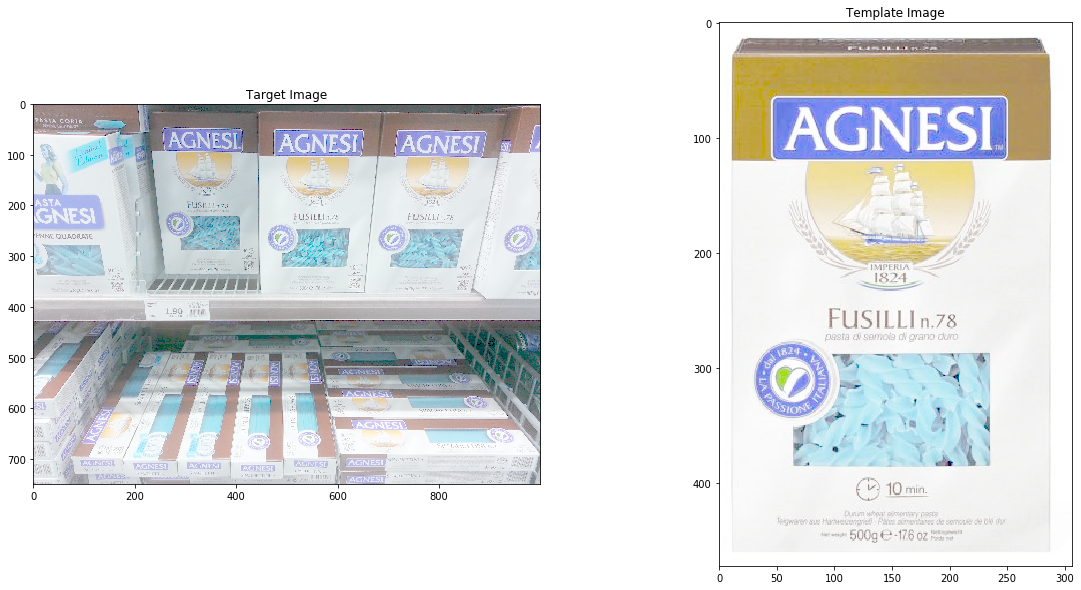

In [3]:
img1 = cv.imread('target1.png')  
img2 = cv.imread('template1.png') 

adjusted = gamma_correction(img1, gamma=4)
adjusted2 = gamma_correction(img2, gamma=3)

img1g = cv.cvtColor(adjusted, cv.COLOR_BGR2GRAY)
img2g = cv.cvtColor(adjusted2, cv.COLOR_BGR2GRAY)

fx, plots = plt.subplots(1, 2, figsize=(20,10))
plots[0].set_title("Target Image")
plots[0].imshow(adjusted)

plots[1].set_title("Template Image")
plots[1].imshow(adjusted2)

In [4]:
'''
    Find keypoints and descriptors with SIFT.
'''
orb = cv.ORB_create()
keypoints1, descriptors1 = orb.detectAndCompute(img1g,None)
keypoints2, descriptors2 = orb.detectAndCompute(img2g,None)

In [5]:
'''
    Find closest matches based on distance.
'''
bf = cv.BFMatcher(cv.NORM_L1, crossCheck = False)
matches = bf.knnMatch(descriptors1,descriptors2,k=2)

best_matches = []
plot_best_matches = []

for m,n in matches:
    if m.distance < 0.70*n.distance:
        plot_best_matches.append([m])
        best_matches.append(m)

In [6]:
'''
    Draw closest matches.
'''
img3 = cv.drawMatchesKnn(img1,keypoints1,img2,keypoints2,plot_best_matches,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (300,300))
plt.imshow(img3)
plt.show()

In [42]:
correspondences = []

'''
    Retrieve matching point correspondences' coordinates
    for each of the images.
'''

for match in best_matches:

    img1_idx = match.queryIdx
    img2_idx = match.trainIdx

    (x1, y1) = keypoints1[img1_idx].pt
    (x2, y2) = keypoints2[img2_idx].pt

    correspondences.append([x2, y2, x1, y1])

In [43]:
'''
    Function to estimate the error:
        || pH - p' ||
'''

def euclidean_distance(correspondence, H):
    
    actualP = np.transpose([correspondence[0], correspondence[1], 1])
    actualPPrime = np.transpose([correspondence[2], correspondence[3], 1])
    
    estimatedPPrime = np.dot(H, actualP)
    estimatedPPrime = estimatedPPrime/estimatedPPrime[2]

    error = np.linalg.norm(actualPPrime - estimatedPPrime)

    return error

In [44]:
'''
    Function to estimate the homography matrix H.
'''
def estimate_homography(correspondences):
    A = []
    
    for cor in correspondences:
        p1 = [cor[0], cor[1], 1]
        p2 = [cor[2], cor[3], 1]

        A.append([-p2[2] * p1[0], -p2[2] * p1[1], -p2[2] * p1[2], 0, 0, 0, p2[0] * p1[0], p2[0] * p1[1], p2[0] * p1[2]])
        A.append([0, 0, 0, -p2[2] * p1[0], -p2[2] * p1[1], -p2[2] * p1[2], p2[1] * p1[0], p2[1] * p1[1], p2[1] * p1[2]])

    U, D, Vt = np.linalg.svd(A)

    H = (Vt[8]/Vt[8][8]).reshape((3,3))  

    return H

In [45]:
def ransac(point_correspondences, threshold):
    max_inliers = []
    H = None
    
    for i in range(1000):
        
        '''
            Pick minimum set of 4 point correspondences
            and estimate a model.
        '''
        random_four_indices = random.sample(range(0, len(point_correspondences)), 4)
        random_four = [point_correspondences[i] for i in random_four_indices]
        
        random_four = np.vstack(random_four)

        
        ''' 
            Estimate homography matrix H,
            based on 4 picked points.
        '''
        current_H = estimate_homography(random_four)
        
        
        '''
            Find inliers within Euclidean distance of 5.
        '''
        inliers = []
        for i in range(len(point_correspondences)):
            distance = euclidean_distance(point_correspondences[i], current_H)
            if distance < 5:
                inliers.append(point_correspondences[i])

        ''' 
            Always update current model,
            when a better one with more inliers
            is available.
        '''
        if len(inliers) > len(max_inliers):
            max_inliers = inliers
            H = current_H
            
        print(" Current Inliers: ", len(inliers), "Max inliers: ", len(max_inliers))
        
        '''
            When inliers of best model so far reach a desired portion of
            all correspondences - conclude the search.
        '''
        if len(max_inliers) > (len(point_correspondences)*threshold):
            break
            
            
    return H, max_inliers


In [ ]:
### Next fields are testing if the Ransac algorithm works. ###
# TODO: Sequential version of the ransac #
# TODO: Function to draw the matched templates outlines #

In [46]:
H, inliers = ransac(correspondences, 0.60)
print("Final homography: ", H)
print("Final inliers count: ", len(inliers))

 Current Inliers:  5 Max inliers:  5
 Current Inliers:  4 Max inliers:  5
 Current Inliers:  5 Max inliers:  5
 Current Inliers:  5 Max inliers:  5
 Current Inliers:  5 Max inliers:  5
 Current Inliers:  4 Max inliers:  5
 Current Inliers:  4 Max inliers:  5
 Current Inliers:  4 Max inliers:  5
 Current Inliers:  6 Max inliers:  6
 Current Inliers:  4 Max inliers:  6
 Current Inliers:  4 Max inliers:  6
 Current Inliers:  6 Max inliers:  6
 Current Inliers:  5 Max inliers:  6
 Current Inliers:  5 Max inliers:  6
 Current Inliers:  4 Max inliers:  6
 Current Inliers:  4 Max inliers:  6
 Current Inliers:  10 Max inliers:  10
 Current Inliers:  5 Max inliers:  10
 Current Inliers:  5 Max inliers:  10
 Current Inliers:  7 Max inliers:  10
 Current Inliers:  5 Max inliers:  10
 Current Inliers:  5 Max inliers:  10
 Current Inliers:  5 Max inliers:  10
 Current Inliers:  5 Max inliers:  10
 Current Inliers:  5 Max inliers:  10
 Current Inliers:  5 Max inliers:  10
 Current Inliers:  4 Max in

 Current Inliers:  5 Max inliers:  12
 Current Inliers:  5 Max inliers:  12
 Current Inliers:  5 Max inliers:  12
 Current Inliers:  4 Max inliers:  12
 Current Inliers:  6 Max inliers:  12
 Current Inliers:  4 Max inliers:  12
 Current Inliers:  2 Max inliers:  12
 Current Inliers:  5 Max inliers:  12
 Current Inliers:  4 Max inliers:  12
 Current Inliers:  2 Max inliers:  12
 Current Inliers:  4 Max inliers:  12
 Current Inliers:  5 Max inliers:  12
 Current Inliers:  4 Max inliers:  12
 Current Inliers:  6 Max inliers:  12
 Current Inliers:  4 Max inliers:  12
 Current Inliers:  4 Max inliers:  12
 Current Inliers:  4 Max inliers:  12
 Current Inliers:  5 Max inliers:  12
 Current Inliers:  4 Max inliers:  12
 Current Inliers:  4 Max inliers:  12
 Current Inliers:  6 Max inliers:  12
 Current Inliers:  4 Max inliers:  12
 Current Inliers:  4 Max inliers:  12
 Current Inliers:  4 Max inliers:  12
 Current Inliers:  4 Max inliers:  12
 Current Inliers:  4 Max inliers:  12
 Current Inl

 Current Inliers:  3 Max inliers:  12
 Current Inliers:  4 Max inliers:  12
 Current Inliers:  4 Max inliers:  12
 Current Inliers:  4 Max inliers:  12
 Current Inliers:  3 Max inliers:  12
 Current Inliers:  6 Max inliers:  12
 Current Inliers:  5 Max inliers:  12
 Current Inliers:  4 Max inliers:  12
 Current Inliers:  4 Max inliers:  12
 Current Inliers:  6 Max inliers:  12
 Current Inliers:  5 Max inliers:  12
 Current Inliers:  4 Max inliers:  12
 Current Inliers:  4 Max inliers:  12
 Current Inliers:  2 Max inliers:  12
 Current Inliers:  2 Max inliers:  12
 Current Inliers:  4 Max inliers:  12
 Current Inliers:  4 Max inliers:  12
 Current Inliers:  5 Max inliers:  12
 Current Inliers:  5 Max inliers:  12
 Current Inliers:  3 Max inliers:  12
 Current Inliers:  5 Max inliers:  12
 Current Inliers:  5 Max inliers:  12
 Current Inliers:  7 Max inliers:  12
 Current Inliers:  5 Max inliers:  12
 Current Inliers:  5 Max inliers:  12
 Current Inliers:  4 Max inliers:  12
 Current Inl

 Current Inliers:  4 Max inliers:  12
 Current Inliers:  5 Max inliers:  12
 Current Inliers:  5 Max inliers:  12
 Current Inliers:  4 Max inliers:  12
 Current Inliers:  5 Max inliers:  12
 Current Inliers:  7 Max inliers:  12
 Current Inliers:  12 Max inliers:  12
 Current Inliers:  5 Max inliers:  12
 Current Inliers:  4 Max inliers:  12
 Current Inliers:  5 Max inliers:  12
 Current Inliers:  6 Max inliers:  12
 Current Inliers:  5 Max inliers:  12
 Current Inliers:  5 Max inliers:  12
 Current Inliers:  5 Max inliers:  12
 Current Inliers:  10 Max inliers:  12
 Current Inliers:  4 Max inliers:  12
 Current Inliers:  12 Max inliers:  12
 Current Inliers:  5 Max inliers:  12
 Current Inliers:  4 Max inliers:  12
 Current Inliers:  5 Max inliers:  12
 Current Inliers:  10 Max inliers:  12
 Current Inliers:  5 Max inliers:  12
 Current Inliers:  3 Max inliers:  12
 Current Inliers:  4 Max inliers:  12
 Current Inliers:  6 Max inliers:  12
 Current Inliers:  4 Max inliers:  12
 Current

In [47]:
inliers1 = []
inliers2 = []
for inlier in inliers:
    inliers1.append([inlier[2],inlier[3]])
    inliers2.append([inlier[0],inlier[1]])

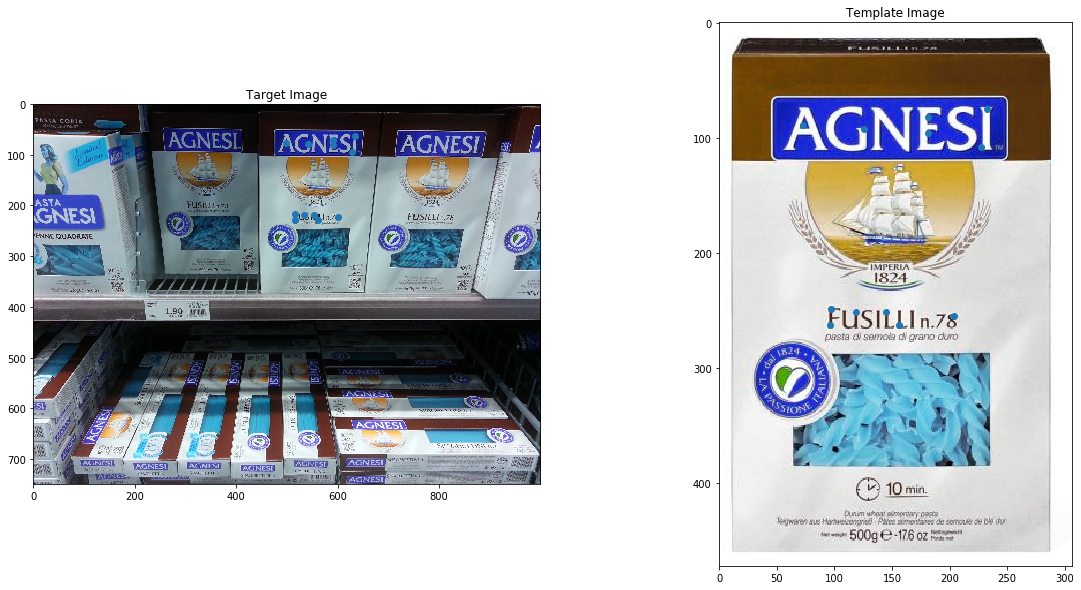

In [48]:
fx, plots = plt.subplots(1, 2, figsize=(20,10))
plots[0].set_title("Target Image")
plots[0].imshow(img1)

plots[1].set_title("Template Image")
plots[1].imshow(img2)

plots[1].scatter(*zip(*inliers2))
plots[0].scatter(*zip(*inliers1))

In [49]:
correspondences = [i for i in correspondences if i not in inliers]

In [50]:
finalH, inliers= ransac(correspondences, 0.60)
print("Final homography: ", finalH)
print("Final inliers count: ", len(inliers))

 Current Inliers:  6 Max inliers:  6
 Current Inliers:  7 Max inliers:  7
 Current Inliers:  5 Max inliers:  7
 Current Inliers:  4 Max inliers:  7
 Current Inliers:  5 Max inliers:  7
 Current Inliers:  4 Max inliers:  7
 Current Inliers:  4 Max inliers:  7
 Current Inliers:  5 Max inliers:  7
 Current Inliers:  4 Max inliers:  7
 Current Inliers:  5 Max inliers:  7
 Current Inliers:  4 Max inliers:  7
 Current Inliers:  5 Max inliers:  7
 Current Inliers:  4 Max inliers:  7
 Current Inliers:  5 Max inliers:  7
 Current Inliers:  8 Max inliers:  8
 Current Inliers:  4 Max inliers:  8
 Current Inliers:  10 Max inliers:  10
Final homography:  [[ 9.74587413e-01  3.69665177e-01  2.03303786e+02]
 [ 3.97975389e-02  1.05952504e+00 -1.87023850e+01]
 [ 3.64202720e-04  8.78030228e-04  1.00000000e+00]]
Final inliers count:  10


In [51]:
inliers1 = []
inliers2 = []
for inlier in inliers:
    inliers1.append([inlier[2],inlier[3]])
    inliers2.append([inlier[0],inlier[1]])

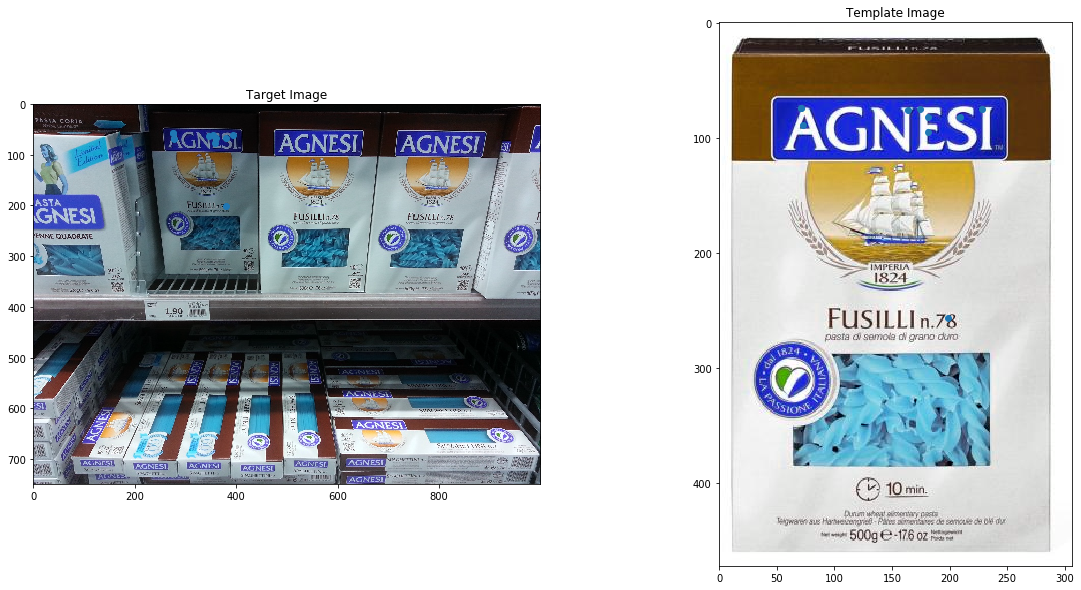

In [52]:
fx, plots = plt.subplots(1, 2, figsize=(20,10))
plots[0].set_title("Target Image")
plots[0].imshow(img1)

plots[1].set_title("Template Image")
plots[1].imshow(img2)

plots[1].scatter(*zip(*inliers2))
plots[0].scatter(*zip(*inliers1))

In [53]:
correspondences = [i for i in correspondences if i not in inliers]

In [54]:
finalH, inliers= ransac(correspondences, 0.75)
print("Final homography: ", finalH)
print("Final inliers count: ", len(inliers))

 Current Inliers:  4 Max inliers:  4
Final homography:  [[-8.87619647e+00  6.79958901e+00  6.99291031e+02]
 [ 3.17944044e+00  1.84641930e+00 -3.19942800e+02]
 [-1.28662802e-02  9.30463876e-03  1.00000000e+00]]
Final inliers count:  4


In [55]:
inliers1 = []
inliers2 = []
for inlier in inliers:
    inliers1.append([inlier[2],inlier[3]])
    inliers2.append([inlier[0],inlier[1]])

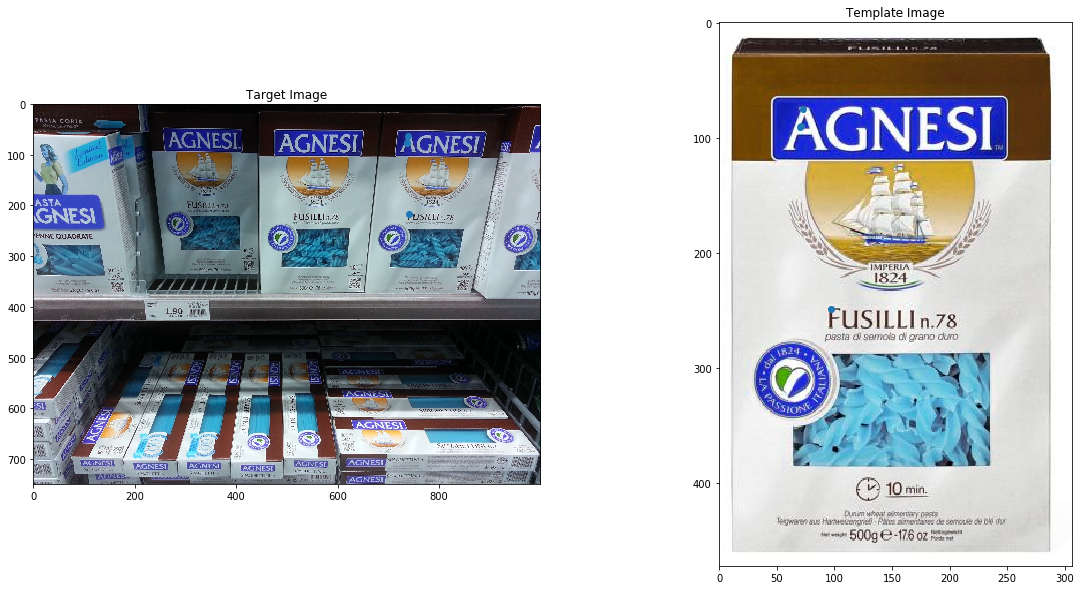

In [56]:
fx, plots = plt.subplots(1, 2, figsize=(20,10))
plots[0].set_title("Target Image")
plots[0].imshow(img1)

plots[1].set_title("Template Image")
plots[1].imshow(img2)

plots[1].scatter(*zip(*inliers2))
plots[0].scatter(*zip(*inliers1))